# 0 - Text classification

## Importation des modules

In [1]:
# Modules de base
import numpy as np
import pandas as pd
import sys

# Ajout d'un chemin
sys.path.append('..')

# Modules de Machine Learning
# Séparation train/test
from sklearn.model_selection import train_test_split
# Métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Pipeline
from sklearn.pipeline import Pipeline
# Classifieurs
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Modules ad hoc
# Modules graphiques
from src.graphs.styles import set_igf_style
from src.graphs.graphs import build_hisplot, build_barplot, build_wordcloud
# Modules de preprocessing
from src.preprocessing.transformers import TokenizerTransformer, TFIDFTransformer, Word2VecTransformer
# Estimateurs
from src.estimators.classifier import LLMClassifier

# Initialisation du style des graphiques
set_igf_style()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bolli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bolli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bolli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importation des données

### Jeu de données d'entraînement

In [2]:
# Importation du jeu de données d'entrainement
data_train = pd.read_excel('../data/data_train.xlsx', index_col='Unnamed: 0')
# Conversion des labels en types numériques
data_train['label'] = data_train['label'].replace({'1' : 0, '8' : 1, '1:8' : 2})
data_train.head(10)

,label,message
0,1,"Madame,Monsieur, je me permet de vous envoyer ..."
5,1,je désire connaitre quel est le montant de mo...
6,1,"Bonjour, Je fais suite du dernier message envo..."
7,1,"Bonjour, Je me permets de vous contacter afin ..."
8,1,"Madame, Monsieur, Après avoir déclaré nos r..."
9,0,Bonjour suite a ma derniere demande et votre r...
10,1,"A l'attention de Madame XXXXX XXXXX Bonjour, J..."
11,0,bonjour j'ai changé d'employeur depuis le 000...
12,0,"Madame, Monsieur, Bonjour, nous sommes XXXXX́s..."
13,1,"Madame, Monsieur bonjour, Je suis désolé mai..."


### Jeu de données de test

In [3]:
# Importation du jeu de données de test
data_test = pd.read_excel('../data/data_test.xlsx', index_col='Unnamed: 0')
data_test.head()

,message
0,"Chère Madame, Cher Monsieur, Impossible de ch..."
1,"Bonjour, mon taux pour le prélévement à la ..."
2,"Bonsoir, Le 0000.0000.0000 ma première fille ..."
3,"Bonjour, Lors de ma déclaration de changement..."
4,Bonjour concernant le prélèvement a la sourc...


## Statistiques descriptives

### Longueur des textes dans les jeux de données d'entraînement et de test

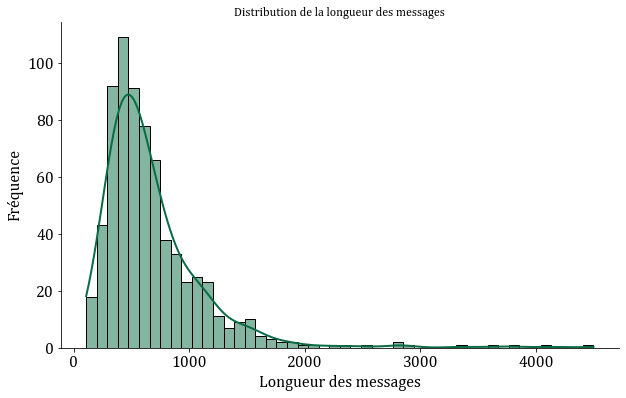

In [4]:
# Construction de la distribution de la longueur des textes
build_hisplot(data=data_train['message'].str.len(), title='Distribution de la longueur des messages', xlabel='Longueur des messages', ylabel='Fréquence')

### Distribution des labels dans le jeu de données d'entraînement

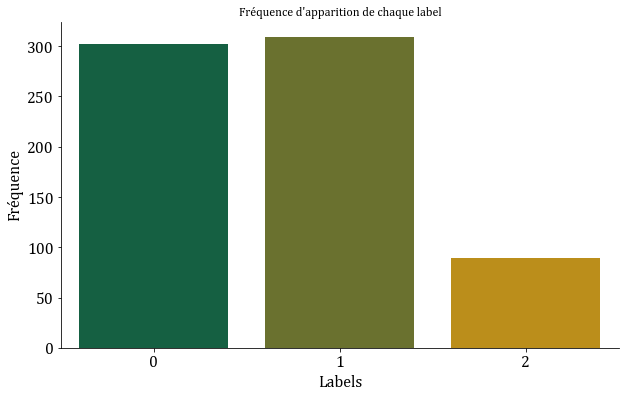

In [5]:
# Distribution des labels
build_barplot(data=data_train['label'], title="Fréquence d'apparition de chaque label", xlabel='Labels', ylabel='Fréquence')

### Caractérisation des textes labélisés

#### Label 1

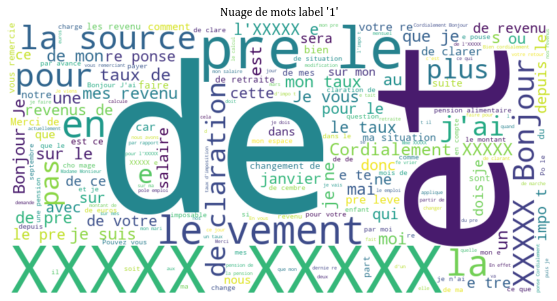

In [6]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==0, 'message']), title="Nuage de mots label '1'")

100%|██████████| 302/302 [00:01<00:00, 164.15it/s]


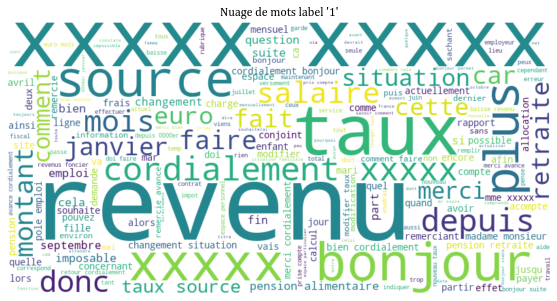

In [7]:
lemmatized_label_1 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==0, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_1['message']), title="Nuage de mots label '1'")

#### Label 8

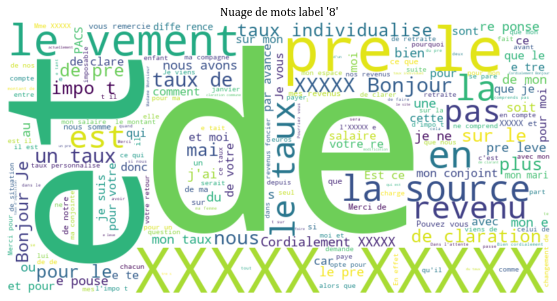

In [8]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==1, 'message']), title="Nuage de mots label '8'")

100%|██████████| 309/309 [00:00<00:00, 781.56it/s]


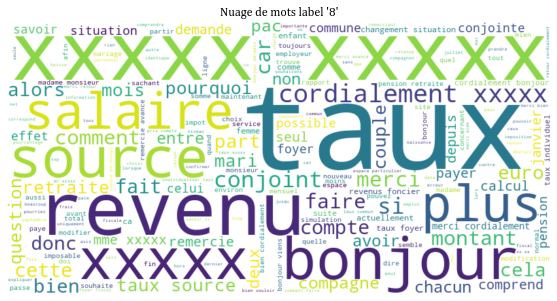

In [9]:
lemmatized_label_8 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==1, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_8['message']), title="Nuage de mots label '8'")

#### Label 1:8

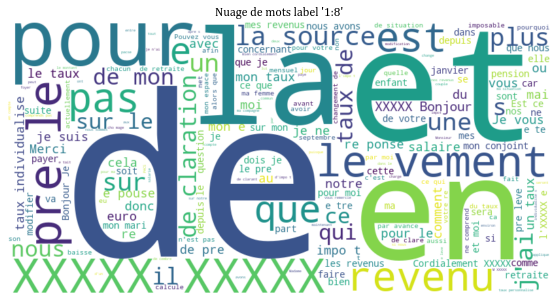

In [10]:
build_wordcloud(text=" ".join(data_train.loc[data_train['label']==2, 'message']), title="Nuage de mots label '1:8'")

100%|██████████| 89/89 [00:00<00:00, 593.97it/s]


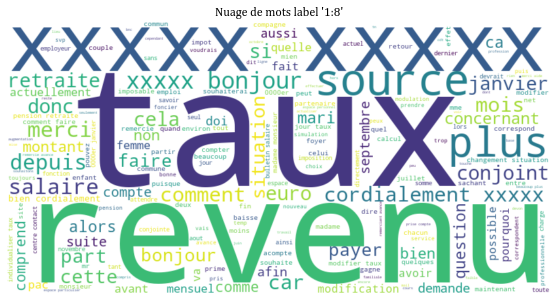

In [11]:
lemmatized_label_18 = TokenizerTransformer(text_colums=['message'], lemmatize=True).fit_transform(data_train.loc[data_train['label']==2, ['message']])
build_wordcloud(text=" ".join(lemmatized_label_18['message']), title="Nuage de mots label '1:8'")

## Preprocessing

In [12]:
# Séparation du jeu de données en jeu de données d'entraînement et jeu de données de validation
train_df, val_df = train_test_split(data_train, test_size=0.2, random_state=42)
# Séparation en X et y
X_train, y_train = train_df.drop('label', axis=1), train_df['label']
X_val, y_val = val_df.drop('label', axis=1), val_df['label']

## Classification des textes

### Embeding de mots : TF-IDF

#### Régression logistique

In [13]:
# Initialisation de la pipeline
pipeline_tfidf_logreg = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('TF-IDF', TFIDFTransformer(text_column='message', max_features=5000)),
    ('LogisticRegression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])
# Entraînement de la pipeline
pipeline_tfidf_logreg.fit(X_train, y_train)
# Prédiction
y_pred_tfidf_logreg = pipeline_tfidf_logreg.predict(X_val)
# Evaluation
print("TF-IDF Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_tfidf_logreg))
print("TF-IDF Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_tfidf_logreg))

100%|██████████| 140/140 [00:00<00:00, 842.06it/s]


TF-IDF Accuracy: 0.7714285714285715
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78        57
           1       0.84      0.81      0.83        70
           2       1.00      0.08      0.14        13

    accuracy                           0.77       140
   macro avg       0.85      0.59      0.58       140
weighted avg       0.80      0.77      0.74       140



#### XGBClassifier

In [14]:
# Initialisation de la pipeline
pipeline_tfidf_xgbc = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('TF-IDF', TFIDFTransformer(text_column='message', max_features=5000)),
    ('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])
# Entraînement de la pipeline
pipeline_tfidf_xgbc.fit(X_train, y_train)
# Prédiction
y_pred_tfidf_xgbc = pipeline_tfidf_xgbc.predict(X_val)
# Evaluation
print("TF-IDF Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_tfidf_xgbc))
print("TF-IDF Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_tfidf_xgbc))

100%|██████████| 140/140 [00:00<00:00, 651.46it/s]

TF-IDF Accuracy: 0.7785714285714286
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        57
           1       0.84      0.81      0.83        70
           2       0.60      0.23      0.33        13

    accuracy                           0.78       140
   macro avg       0.72      0.63      0.65       140
weighted avg       0.77      0.78      0.77       140



### Embeding de mots en tenant compte de leur contexte : Word2Vec

#### Régression logistique

In [15]:
# Initialisation de la pipeline
pipeline_word2vec_logreg = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('Word2Vec', Word2VecTransformer(text_column='message', num_features=100, window=5)),
    ('LogisticRegression', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])
# Entraînement de la pipeline
pipeline_word2vec_logreg.fit(X_train, y_train)
# Prédiction
y_pred_word2vec_logreg = pipeline_word2vec_logreg.predict(X_val)
# Evaluation
print("Word2Vec Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_word2vec_logreg))
print("Word2Vec Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_word2vec_logreg))

100%|██████████| 560/560 [00:00<00:00, 795.70it/s]


(560, 100)


100%|██████████| 140/140 [00:00<00:00, 827.83it/s]


(140, 100)
Word2Vec Accuracy: 0.39285714285714285
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.86      0.54        57
           1       0.38      0.09      0.14        70
           2       0.00      0.00      0.00        13

    accuracy                           0.39       140
   macro avg       0.26      0.32      0.23       140
weighted avg       0.35      0.39      0.29       140



c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bolli\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBClassifier

In [16]:
# Initialisation de la pipeline
pipeline_word2vec_xgbc = Pipeline([
    ('Tokenizer', TokenizerTransformer(text_colums=['message'], lemmatize=True)),
    ('Word2Vec', Word2VecTransformer(text_column='message', num_features=100, window=5)),
    ('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])
# Entraînement de la pipeline
pipeline_word2vec_xgbc.fit(X_train, y_train)
# Prédiction
y_pred_word2vec_xgbc = pipeline_word2vec_xgbc.predict(X_val)
# Evaluation
print("Word2Vec Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_word2vec_xgbc))
print("Word2Vec Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_word2vec_xgbc))

100%|██████████| 560/560 [00:00<00:00, 875.80it/s]


(560, 100)


100%|██████████| 140/140 [00:00<00:00, 438.56it/s]

(140, 100)
Word2Vec Accuracy: 0.55
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57        57
           1       0.60      0.59      0.59        70
           2       0.17      0.08      0.11        13

    accuracy                           0.55       140
   macro avg       0.43      0.43      0.42       140
weighted avg       0.53      0.55      0.54       140



### Embeding de phrases : BERT (masked language modelling)

In [17]:
# Initialisation du classifier
camembert_clf = LLMClassifier(text_column='message')
# Entraînement du classifier
camembert_clf.fit(X_train, y_train)

# Prédiction
y_pred_camembert = camembert_clf.predict(X_val)
# Evaluation
print("BERT Accuracy:", accuracy_score(y_true=y_val, y_pred=y_pred_camembert))
print("BERT Classification Report:\n", classification_report(y_true=y_val, y_pred=y_pred_camembert))

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/560 [00:00<?, ? examples/s]

c:\Users\bolli\anaconda3\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

### Description en langage naturel des catégories (causal language modelling) : Zero shot classification

In [ ]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
df = pd.read_csv('your_dataset.csv')

# Ensure the labels are numerical
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Text and labels
texts = df['text'].tolist()
labels = df['label'].tolist()

# Define possible labels as descriptive names
label_descriptions = {
    0: "Question portant sur la déclaration de revenu de l'individu",
    1: "Question portant sur la déclaration de revenu du conjoint de l'individu",
    2: "Question portant sur la déclaration de renu de l'individu et de son conjoint",
    # Add more labels as needed
}

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate labels using their descriptions
candidate_labels = [description for description in label_descriptions.values()]

# Perform zero-shot classification
results = classifier(texts, candidate_labels=candidate_labels, multi_label=False)

# Map predicted descriptions back to numerical labels
reverse_label_mapping = {v: k for k, v in label_descriptions.items()}
predicted_labels = [reverse_label_mapping[result['labels'][0]] for result in results]

# Calculate accuracy
accuracy = accuracy_score(labels, predicted_labels)
print("Zero-Shot Classification Accuracy:", accuracy)

# Print classification report
report = classification_report(labels, predicted_labels, target_names=[str(label) for label in label_descriptions.keys()])
print("Zero-Shot Classification Report:\n", report)


## Rapport

Evaluation sur :
- Le workflow
- Le preprocessing (causal language modelling vs masked language modelling)
- Les métriques utilisées
- L'évaluation des résultats

Voir sur la lemmatisation